# 02 – Model Training (XGBoost)

In this notebook, we will:

- Load the cleaned credit card fraud dataset.
- Perform preprocessing and train-test split.
- Train an XGBoost classifier to predict fraud.
- Save the trained model for future use.

This model will later be used to score transactions in the Streamlit app.



In [17]:
!pip install xgboost joblib scikit-learn --quiet

import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
import os


## Load Dataset

We load a sample of the full dataset for training. Later, we will integrate with the complete dataset during deployment or large-scale training.


In [18]:
# Load merged dataset
df = pd.read_csv('/content/merged_fraud_dataset.csv')  # Adjust path if needed

# Preview dataset
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,id
0,156779.000000,-0.888319,1.551782,-1.254353,-1.178184,0.618713,-1.525601,1.190115,0.152031,-0.316529,...,0.946047,-0.161775,0.039476,-0.269840,0.082890,0.474943,0.320537,8.99,0,254539
1,30160.737902,0.150664,0.719368,-0.813954,1.304551,0.608530,-1.708730,-0.013450,-0.110836,-0.797498,...,-0.568152,-0.565164,0.233635,2.454897,1.058056,0.733354,1.145127,11195.72,1,853146
2,58988.258985,-0.743341,0.524120,-0.319596,-0.991261,-0.398589,-0.297605,-0.034214,0.634144,0.428446,...,-0.714539,0.481388,-0.066491,-0.296562,0.386444,-0.234732,-0.128378,22752.97,0,462633
3,61466.000000,0.782048,-0.122077,0.323407,2.418056,0.029235,0.702427,0.024739,0.312446,-0.835219,...,0.490129,-0.187922,-0.295750,0.365694,0.176568,-0.023010,0.024074,152.13,0,86945
4,67135.070081,1.822436,-0.477496,-0.038215,-0.560011,0.460353,0.335919,0.383116,-0.174881,2.075916,...,0.526747,-0.067710,0.057417,0.457387,-1.149393,-0.280869,-0.276916,639.81,0,443112


In [19]:
# Shape and basic info
print("Shape of dataset:", df.shape)
df.info()
df.describe()


Shape of dataset: (853437, 32)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 853437 entries, 0 to 853436
Data columns (total 32 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    853437 non-null  float64
 1   V1      853437 non-null  float64
 2   V2      853437 non-null  float64
 3   V3      853437 non-null  float64
 4   V4      853437 non-null  float64
 5   V5      853437 non-null  float64
 6   V6      853437 non-null  float64
 7   V7      853437 non-null  float64
 8   V8      853437 non-null  float64
 9   V9      853437 non-null  float64
 10  V10     853437 non-null  float64
 11  V11     853437 non-null  float64
 12  V12     853437 non-null  float64
 13  V13     853437 non-null  float64
 14  V14     853437 non-null  float64
 15  V15     853437 non-null  float64
 16  V16     853437 non-null  float64
 17  V17     853437 non-null  float64
 18  V18     853437 non-null  float64
 19  V19     853437 non-null  float64
 20  V20     853437 no

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,id
count,853437.000000,8.534370e+05,8.534370e+05,8.534370e+05,8.534370e+05,8.534370e+05,8.534370e+05,8.534370e+05,8.534370e+05,8.534370e+05,...,8.534370e+05,8.534370e+05,8.534370e+05,8.534370e+05,8.534370e+05,8.534370e+05,8.534370e+05,853437.000000,853437.000000,853437.00000
mean,88898.536213,3.740720e-16,7.617564e-17,-4.148927e-16,6.800067e-16,3.348581e-16,5.103297e-16,-1.749887e-16,4.754785e-17,-7.844022e-16,...,-1.172836e-16,9.244398e-17,1.483575e-15,1.497120e-16,5.627897e-16,-1.345011e-16,-1.809166e-17,8052.827520,0.333718,426719.00000
std,48978.533495,1.395200e+00,1.255496e+00,1.197292e+00,1.155543e+00,1.141070e+00,1.121879e+00,1.084898e+00,1.068795e+00,1.033962e+00,...,9.176234e-01,8.924216e-01,8.880840e-01,8.700369e-01,8.624886e-01,8.489122e-01,8.382382e-01,7980.903363,0.471541,246366.18518
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-1.093314e+01,-4.480774e+01,-4.067968e+00,-1.361263e+01,-8.226969e+00,-2.256568e+01,-3.903524e+01,0.000000,0.000000,1.00000
25%,47524.782143,-6.823970e-01,-5.064883e-01,-6.883446e-01,-7.219500e-01,-4.307846e-01,-6.130605e-01,-3.875514e-01,-1.946538e-01,-5.979740e-01,...,-5.057740e-01,-2.108657e-01,-5.353059e-01,-4.585099e-01,-5.049413e-01,-2.583094e-01,-1.538807e-01,75.930000,0.000000,213360.00000
50%,85576.772569,-8.152553e-02,-9.337775e-02,3.654564e-02,-5.880031e-02,5.403578e-02,-1.486917e-02,1.800122e-01,-8.737144e-02,4.670245e-02,...,-1.650071e-02,-4.098598e-02,3.015686e-02,1.813021e-03,-3.410912e-02,-5.293470e-02,4.151412e-03,6045.950000,0.000000,426719.00000
75%,133004.000000,1.006219e+00,4.782555e-01,7.518550e-01,7.183214e-01,4.806525e-01,4.781018e-01,5.347508e-01,1.373579e-01,5.694575e-01,...,4.848806e-01,1.525449e-01,5.602493e-01,4.618753e-01,4.872230e-01,1.951870e-01,2.108455e-01,15024.850000,1.000000,640078.00000
max,172792.000000,2.454930e+00,2.205773e+01,1.412583e+01,1.687534e+01,4.271689e+01,7.330163e+01,2.178730e+02,2.000721e+01,2.027006e+01,...,1.263251e+01,3.170763e+01,1.296564e+01,1.462151e+01,5.623285e+00,1.132311e+02,7.725594e+01,25691.160000,1.000000,853437.00000


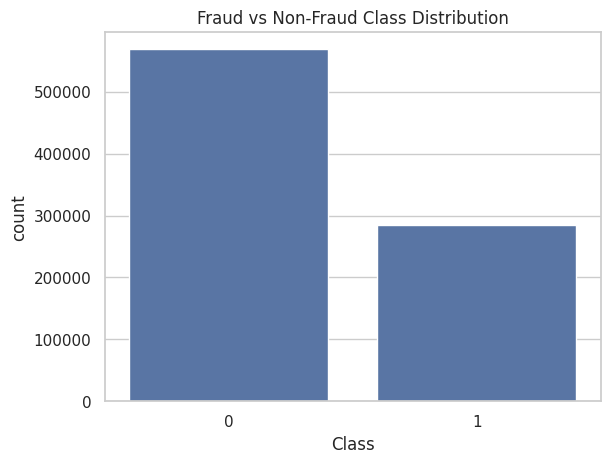

Class
0    568630
1    284807
Name: count, dtype: int64


In [20]:
# Check missing values
df.isnull().sum()

# Class balance
sns.countplot(x='Class', data=df)
plt.title('Fraud vs Non-Fraud Class Distribution')
plt.show()

print(df['Class'].value_counts())


### 📘 Step 4: Data Preprocessing & Handling Class Imbalance

In this step, we prepare our data for model training. Credit card fraud datasets are highly imbalanced, meaning very few transactions are fraudulent. If we train on this as-is, the model may learn to always predict “non-fraud” — giving high accuracy but failing to detect actual fraud.
#### 🔹 4.1 Preprocessing

We’ll:
- Drop any unnecessary columns (like `Index`, `ID`)
- Split the data into training and test sets
- Standardize the features for better model performance


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Drop unwanted columns if any (like Index, ID if present)
drop_cols = [col for col in ['Index', 'ID', 'Unnamed: 0'] if col in df.columns]
df = df.drop(columns=drop_cols)

# Separate features and labels
X = df.drop(columns='Class')
y = df['Class']

# Optional: Scale features (excluding time if retained)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

print("Train class distribution:\n", y_train.value_counts())
print("Test class distribution:\n", y_test.value_counts())


Train class distribution:
 Class
0    454904
1    227845
Name: count, dtype: int64
Test class distribution:
 Class
0    113726
1     56962
Name: count, dtype: int64


#### ⚖️ 4.2 Addressing Class Imbalance with SMOTE

To avoid biasing the model toward the majority class, we use SMOTE (Synthetic Minority Over-sampling Technique) to generate synthetic examples of the minority (fraud) class.


In [22]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training set
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Resampled training class distribution:\n", y_train_res.value_counts())


Resampled training class distribution:
 Class
0    454904
1    454904
Name: count, dtype: int64


✅ At this point:
- The data is split and scaled
- The training set is balanced using SMOTE
- We're ready to train a fraud detection model! 🎯

⬇️ Next: we’ll train a baseline XGBoost model and evaluate its performance.


### 5.2 Train the Model

We initialize an `XGBClassifier` and train it on our balanced training set (after SMOTE). We also generate predictions and probability scores for the test set.


In [23]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Initialize and train the model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train_res, y_train_res)

# Predict on test set
y_pred = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)[:, 1]


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:05:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


### 5.3 Evaluate Model Performance

We use the following metrics to evaluate the model:

- Precision, Recall, F1-score (via classification report)
- Confusion Matrix
- ROC AUC Score (important for imbalanced classification tasks)


In [24]:
# Classification Report
print("📄 Classification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
print("🧮 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# ROC AUC Score
auc_score = roc_auc_score(y_test, y_proba)
print(f"\n🚀 ROC AUC Score: {auc_score:.4f}")


📄 Classification Report:

              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998    113726
           1     0.9999    0.9992    0.9995     56962

    accuracy                         0.9997    170688
   macro avg     0.9997    0.9996    0.9997    170688
weighted avg     0.9997    0.9997    0.9997    170688

🧮 Confusion Matrix:
[[113718      8]
 [    45  56917]]

🚀 ROC AUC Score: 1.0000


### 5.4 Visualize ROC Curve (optional but useful)

The ROC (Receiver Operating Characteristic) curve shows the tradeoff between the true positive rate and false positive rate. A higher area under the curve (AUC) indicates better performance.


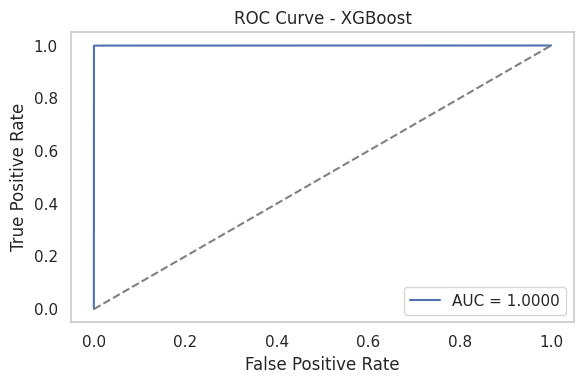

In [25]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


✅ At this point:

- We’ve trained a powerful baseline model using XGBoost.
- We evaluated it using robust classification metrics.
- We are now ready to:
  - Save the model
  - Integrate a 2FA simulation trigger
  - Start building our Streamlit interface.


In [26]:
import joblib
import os

# Create a directory for saved artifacts
os.makedirs("models", exist_ok=True)

# Save model and scaler
joblib.dump(xgb, "models/fraud_model.pkl")
joblib.dump(scaler, "models/scaler.pkl")

print("✅ Model and scaler saved to 'models/' folder.")


✅ Model and scaler saved to 'models/' folder.


In [29]:
# Optional: Use reusable preprocessing function (as we decide to move logic into src/)
from src.preprocessing import preprocess_data
import joblib
from pathlib import Path
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler # Import StandardScaler explicitly

# Re-run preprocessing to get the variables
X_train, X_test, y_train, y_test, preprocessor = preprocess_data(df)

# Note: After running the above line, X_train, X_test, y_train, y_test are
# likely NumPy arrays, depending on the implementation of preprocess_data.
# If preprocess_data returns arrays, cannot use .iloc

Path("models").mkdir(exist_ok=True)

# Save model and preprocessor (using the preprocessor variable from preprocess_data)
joblib.dump(xgb, "models/xgb_model.pkl")
joblib.dump(preprocessor, "models/preprocessor.pkl") # Use preprocessor from the function output

# Optional: Define threat score threshold logic for 2FA
def trigger_2fa(threat_score, threshold=0.5):
    if threat_score >= threshold:
        print("🔐 High fraud risk detected. Triggering 2FA verification.")
    else:
        print("✅ No suspicious activity detected.")

# Example: use model's predicted probability
example_score = xgb.predict_proba(X_test[0:1])[0][1]
trigger_2fa(example_score)

✅ No suspicious activity detected.


In [30]:
from src.preprocessing import preprocess_data
from src.model import train_model, save_model
